Redes Convolucionales Sep-Dic 2023

Raúl Guaidó 16-10486

In [1]:
################################
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import  f1_score, accuracy_score, confusion_matrix
from google.colab import drive
################################

Configuracion del DRive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/CNN Projects/Tarea2-Cifar10
%ls

[Errno 2] No such file or directory: '/content/drive/MyDrive/CNN Projects/Tarea2-Cifar10'
/content
drive/  sample_data/


Descarga y normalizacion de la data

In [5]:
transform = transforms.Compose(
    [ToTensor(),
     transforms.Normalize(mean =[0.51, 0.46, 0.40], std =[0.22, 0.22, 0.22])])

batch_size = 5

train_set = torchvision.datasets.CIFAR10(root='./data_src', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data_src', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)

classes = ('Avion', 'Automovil', 'Ave', 'Gato', 'Ciervo', 'Perro', 'Rana', 'Caballo', 'Barco', 'Camion')

100%|██████████| 170498071/170498071 [00:01<00:00, 89135932.68it/s]


Extracting ./data_src/cifar-10-python.tar.gz to ./data_src
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Visualizacion de la data

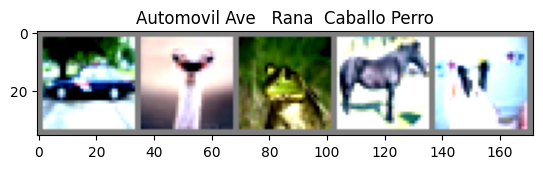

In [6]:
def imagenshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

imagenshow(torchvision.utils.make_grid(images))


Definicion del Modelo de la CNN

In [7]:
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 20, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(20, 40, 5)
        self.fc1 = nn.Linear(40* 5* 5, 420)
        self.fc2 = nn.Linear(420, 180)
        self.fc3 = nn.Linear(180, 80)
        self.fc4 = nn.Linear(80, 20)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return x


CNN1 = CNN1()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CNN1.parameters(), lr=0.002, momentum=0.85)

Entrenamiento del Modelo de la CNN

In [8]:
array_loss= []


for epoch in range(10):

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = CNN1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    if i % 2000 == 1999:
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / len(train_loader):.3f}')

    array_loss.append((running_loss)/len(train_loader))

print('Finished Training')

[1, 10000] loss: 1.473
[2, 10000] loss: 1.112
[3, 10000] loss: 0.959
[4, 10000] loss: 0.852
[5, 10000] loss: 0.761
[6, 10000] loss: 0.677
[7, 10000] loss: 0.604
[8, 10000] loss: 0.539
[9, 10000] loss: 0.485
[10, 10000] loss: 0.451
Finished Training


Carga del modelo entrenado en la carpeta 'Training_Model.pt'



In [9]:
PATH = './Training_Model.pt'
torch.save({
            'epoch': epoch,
            'model_state_dict': CNN1.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': running_loss,
            }, PATH)

Calculo de la precision del modelo ya entrenado

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN1(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 69 %


Mapa de calor para la primera capa Convlucional

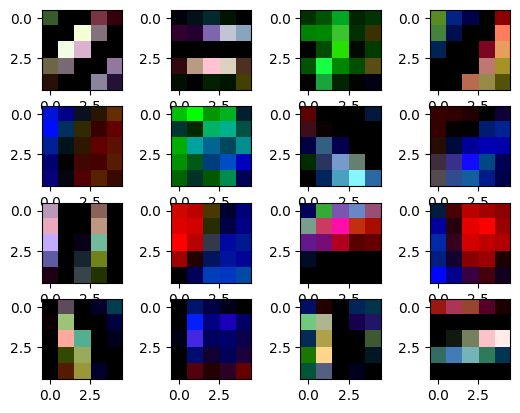

In [11]:
weight1 = []

for x in CNN1.state_dict()['conv1.weight']:
      w1 = np.transpose(x)
      w1 = w1/w1.max()
      w1 = np.clip(w1, 0, 1)
      weight1.append(w1)

figure, axes = plt.subplots(nrows=4, ncols=4)

for a, b in zip(axes.ravel(), range(20)):
  nimage = np.random.randint(len(weight1))
  a.imshow(weight1[b])

Mapa de calor para la segunda capa convolucional

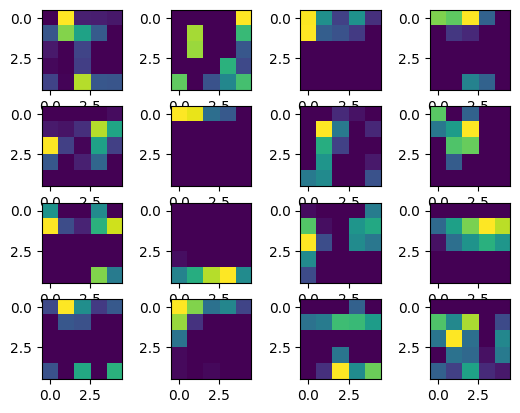

In [12]:
weight2 = []
for x in CNN1.state_dict()['conv2.weight']:
  for w in x:
      w2 = w
      w2 = w2/w2.max()
      w2 = np.clip(w2, 0, 1)
      weight2.append(w2)

figure, axes = plt.subplots(nrows=4, ncols=4)

for a, b in zip(axes.ravel(), range(30)):
  nimage = np.random.randint(len(weight2))
  a.imshow(weight2[b])